## Electricity Consumption Prediction

---

![](https://images.unsplash.com/photo-1521618755572-156ae0cdd74d?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1656&q=80)
Photo by [Zbynek Burival](https://unsplash.com/photos/V4ZYJZJ3W4M)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#I.-Key-concepts-in-time-series" data-toc-modified-id="I.-Key-concepts-in-time-series-1">I. Key concepts in time series</a></span></li><li><span><a href="#III.-Decomposition-and-forecasting" data-toc-modified-id="III.-Decomposition-and-forecasting-2">III. Decomposition and forecasting</a></span><ul class="toc-item"><li><span><a href="#1.-Trends" data-toc-modified-id="1.-Trends-2.1">1. Trends</a></span></li><li><span><a href="#2.-Seasonality" data-toc-modified-id="2.-Seasonality-2.2">2. Seasonality</a></span></li><li><span><a href="#3.-Automatic-Decomposition" data-toc-modified-id="3.-Automatic-Decomposition-2.3">3. Automatic Decomposition</a></span></li><li><span><a href="#4.-Model-the-stationary-series" data-toc-modified-id="4.-Model-the-stationary-series-2.4">4. Model the stationary series</a></span><ul class="toc-item"><li><span><a href="#Moving-Average-(MA)-processes" data-toc-modified-id="Moving-Average-(MA)-processes-2.4.1">Moving Average (MA) processes</a></span></li><li><span><a href="#Auto-Regressive-(AR)-processes" data-toc-modified-id="Auto-Regressive-(AR)-processes-2.4.2">Auto Regressive (AR) processes</a></span></li><li><span><a href="#Auto-Regressive-Moving-Average-(ARMA)-processes" data-toc-modified-id="Auto-Regressive-Moving-Average-(ARMA)-processes-2.4.3">Auto Regressive Moving Average (ARMA) processes</a></span></li><li><span><a href="#Auto-Regressive-Integrated-Moving-Average-(ARIMA)-processes" data-toc-modified-id="Auto-Regressive-Integrated-Moving-Average-(ARIMA)-processes-2.4.4">Auto Regressive Integrated Moving Average (ARIMA) processes</a></span></li><li><span><a href="#Seasonal-Autoregressive-Integrated-Moving-Average-(SARIMA)-process" data-toc-modified-id="Seasonal-Autoregressive-Integrated-Moving-Average-(SARIMA)-process-2.4.5">Seasonal Autoregressive Integrated Moving-Average (SARIMA) process</a></span></li><li><span><a href="#Time-series-recomposition" data-toc-modified-id="Time-series-recomposition-2.4.6">Time series recomposition</a></span></li></ul></li><li><span><a href="#5.-Using-Prophet" data-toc-modified-id="5.-Using-Prophet-2.5">5. Using Prophet</a></span></li></ul></li></ul></div>

In this exercise, you will be asked to use insights from the previous exploration, and build forecasts for the electricity consumption.

You will be working with time series of Open Power System Data ([OPSD](https://open-power-system-data.org/)) for Germany. 

The data set includes daily electricity consumption, wind power production, and solar power production between 2006 and 2017. 
```
- Date — The date (yyyy-mm-dd format)
- Consumption — Electricity consumption in GWh
- Wind — Wind power production in GWh
- Solar — Solar power production in GWh
- Wind+Solar — Sum of wind and solar power production in GWh
```

In [21]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from statsmodels.tsa.arima.model import ARIMA

In [22]:
# Load file
df = pd.read_csv('opsd_germany_daily.csv', index_col=0)
df.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


## I. Key concepts in time series

For what comes next, we will only focus on the consumption (and the prediction of the consumption). 

Q1 - Plot the autocorrelation and partial autocorrelation of the consumption. What do you notice ?

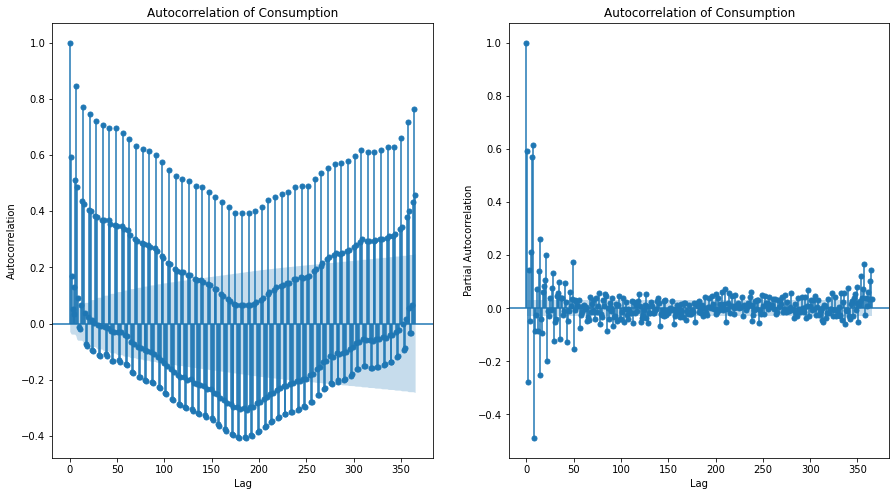

In [23]:
import statsmodels.api as sm

consumption = df["Consumption"]
fig, axes = plt.subplots(1, 2, figsize=(15,8))

sm.graphics.tsa.plot_acf(consumption, lags=365, ax=axes[0])
sm.graphics.tsa.plot_pacf(consumption, lags=365, ax=axes[1])

# Add labels to the first subplot
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")
axes[0].set_title("Autocorrelation of Consumption")

# Add labels to the second subplot
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].set_title("Autocorrelation of Consumption")

plt.show()

There seems to ba a quite strong autocorrelation over time between the current values and the values 365 days ago, meaning that there is a cyclical effect in the consumption.

 The ACF plot shows a cyclical pattern with peaks and troughs at regular intervals, which suggests strong seasonality in consumption data. The pattern appears to repeat approximately every 50 lags over 365 days, which could correspond to a weekly seasonality if the data is daily. The autocorrelations start high at lag 0 (which is always 1) and gradually decline, but remain positive for a long period, indicating a slowly decaying correlation as the lags increase. This suggests persistence in consumption; that is, high consumption today means likely high consumption tomorrow and so on, but the influence weakens as time passes. The shaded area around the autocorrelation signifies confidence intervals. Many peaks extend beyond the confidence intervals, confirming the significance of the seasonality and autocorrelation at various lags.

 The PACF plot exhibits a sharp cut-off after the first lag, then there are a few significant lags scattered, which suggests that there may be a few specific lags that have a strong influence on the series after accounting for the intervening lags. The first lag is significantly positive, indicating a direct relationship between a day's consumption and the previous day's. There are also a few other significant spikes at higher lags, though these are not as defined or regular as the ACF plot. Beyond the initial lags, the PACF values hover around zero, which implies that there are no significant relationships at those lags once the effect of the previous lags has been accounted for.

 The combination of the ACF and PACF suggests a time series that may be well described by a seasonal ARIMA model, considering the strong seasonal component and significant autocorrelation at lag 1.

Q2 - Is the series stationary ? 

In [24]:
# ADFuller 
from statsmodels.tsa.stattools import adfuller

result = adfuller(consumption)
print("ADF Statistic: ", round(result[0], 6))
print("p-value: ", round(result[1], 6))
print("Critical Values:")
print("\t 1%: ", round(result[4]["1%"], 3))
print("\t 1%: ", round(result[4]["1%"], 3))
print("\t 5%: ", round(result[4]["5%"], 3))
print("\t 10%: ", round(result[4]["10%"], 3))

ADF Statistic:  -6.239148
p-value:  0.0
Critical Values:
	 1%:  -3.432
	 1%:  -3.432
	 5%:  -2.862
	 10%:  -2.567


The series is stationary according to the ADFuller test. As the ADF value is more negative than the critical values, which means the series can be considered stationary. The p-value is 0, which is less than the common alpha value of 0.05. This means that the time series does not have a unit root, and it does not exhibit trends or seasonal patterns that are dependent on time, which is congruent with the properties of a stationary time series.


Q3 - Can you thing of any technique that could help our future model be more precise ?

We could try a de-trending (although there is no clear trend). We could also remove the seasonality in the time series.

Even in the absence of a clear or strong trend, removing a subtle trend can sometimes improve model accuracy. De-trending makes the series more stationary, which is an assumption of many time series forecasting models. This could include differencing, transformation, detrend by regression, or moving average. 

## III. Decomposition and forecasting

### 1. Trends

Q4 - Try to apply de-trending. Is it interesting ? 

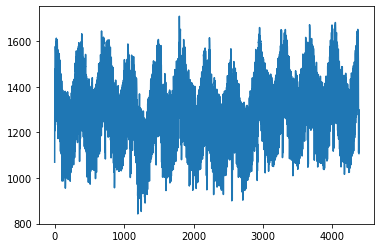

In [25]:
# LinearRegression                
from sklearn.linear_model import LinearRegression

X = np.array(range(len(consumption)))
y = consumption

reg = LinearRegression().fit(X.reshape(-1, 1), y)
pred_line = reg.predict(X.reshape(-1,1))   

plt.plot(consumption.values)


The plot above shows the consumption.values. 

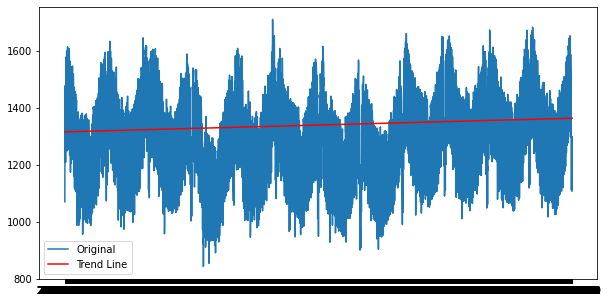

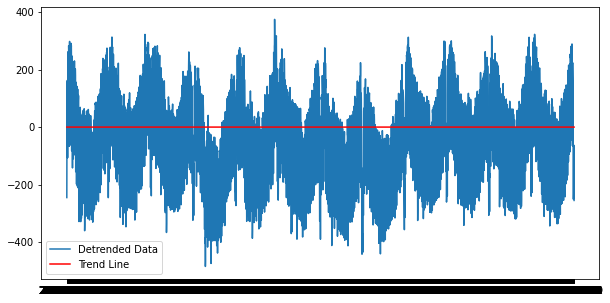

In [26]:
#calculate the detrended data (residuals)
detrended = y - pred_line

#plot original data and trend vs detrend
plt.figure(figsize=(10, 5))
plt.plot(consumption.index, consumption.values, label='Original')
plt.plot(consumption.index, pred_line, label='Trend Line', color='red')
plt.legend()

X = np.array(range(len(consumption)))
y = detrended
reg = LinearRegression().fit(X.reshape(-1, 1), y)
pred_line = reg.predict(X.reshape(-1,1))   

plt.figure(figsize=(10, 5))
plt.plot(consumption.index, detrended, label='Detrended Data')
plt.plot(consumption.index, pred_line, label='Trend Line', color='red')
plt.legend()
plt.show()

Evidently, the regression method was used by taking the linear aggression from the original data and using it to detrend. Subtracting the trend line from the original data detrended the data, as represented by the red trend line in both plots. There is a clear increasing trend in the original data in plot 1, then a flat line with no increasing or decreasing trend after it is detrended. 

The detrended plot has  analytical value because it emphasises the cyclical components of the time series, free from linear trend. This makes patterns related to seasonality and other non-linear factors more apparent for further analysis. The flatness of the trend line suggests that any linear trend present in the original data is not statistically significant, which aligns with the stationarity of the data indicated by the ADF test. This means that linear detrending might not have been necessary in this case. The detrended data shows patterns of potential seasonality that weren't altered by removing the trend. These would be the next focus for model improvement, using seasonal decomposition, seasonal differencing, or by incorporating seasonal terms in a SARIMA model.

Overall, the detrended plot is useful for confirming the absence of a significant linear trend and for further investigating other characteristics of the data such as seasonality and variance over time. 


In [27]:
# polyfit & log trend + exp trend
a_1,b_1 = np.polyfit(np.log(X+1), y, 1)
a_2,b_2 = np.polyfit(X+1, np.log(y), 1)
pred_log = a_1 * np.log(X+1) + b_1
pred_exp = np.exp(b_2) + np.exp( (X+1) * a_2)

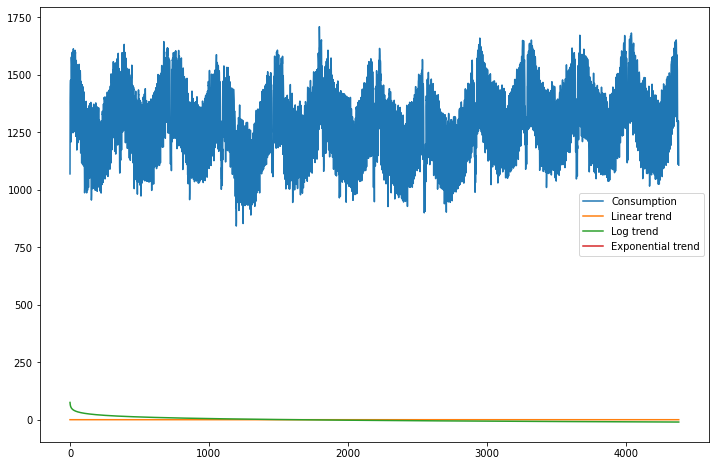

In [28]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(consumption.values, label="Consumption")
plt.plot(pred_line, label="Linear trend")
plt.plot(pred_log, label="Log trend")
plt.plot(pred_exp, label="Exponential trend")
plt.legend()
plt.show()

In this case, there seems to be no clear trend pattern. We could consier skipping the de-trending.

We will apply a log transform for what comes next :

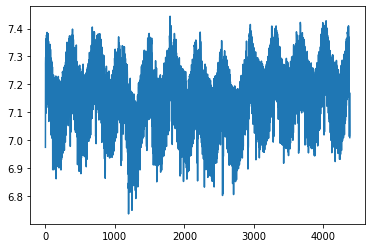

In [29]:
series = np.log(consumption.values)
plt.plot(series)

### 2. Seasonality

Q5 - Try to remove the seasonality. Is it interesting ? 

If we observe some seasonality over a year, the easiest option to remove the trend is to compute the first difference. For example, if there is a yearly seasonality, we can take $ y_t $ - $ y_{t-365} $

In [30]:
from scipy.ndimage.interpolation import shift

In [31]:
# series
series = shift(series, 365, cval=np.NaN)
series = series[np.isfinite(series)]

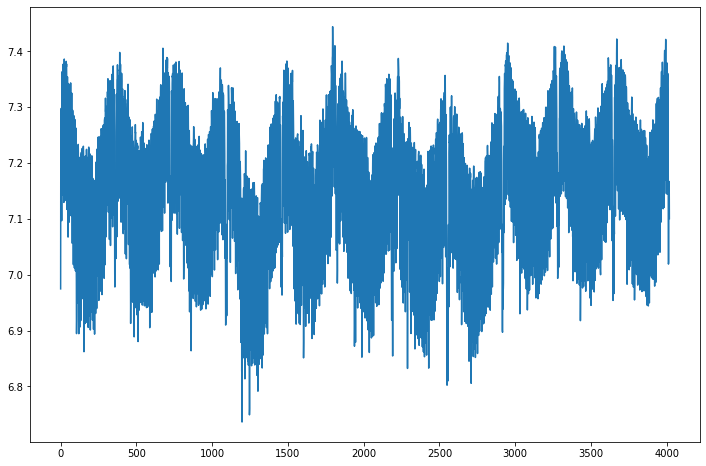

In [32]:
# plot
plt.figure(figsize=(12,8))
plt.plot(series, label="linear trend")
plt.show()

We have removed most of the trend here, and it seems like we remain with a stationary series.

Q6 - How does the ADFuller test compare now ? Did you improve anything ?

In [33]:
# ADFuller
from statsmodels.tsa.stattools import adfuller

result = adfuller(series)
print("ADF Statistic: ", round(result[0], 6))
print("p-value: ", round(result[1], 6))
print("Critical Values:")
print("\t 1%: ", round(result[4]["1%"], 3))
print("\t 1%: ", round(result[4]["1%"], 3))
print("\t 5%: ", round(result[4]["5%"], 3))
print("\t 10%: ", round(result[4]["10%"], 3))

ADF Statistic:  -6.135816
p-value:  0.0
Critical Values:
	 1%:  -3.432
	 1%:  -3.432
	 5%:  -2.862
	 10%:  -2.567


Removing the trend did not improve anything. We will stay with the initial series.

### 3. Automatic Decomposition

Q7 - Does the automatic decomposition of `statsmodels` identify anything else ?

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition
decomposition = seasonal_decompose(series, period=365, extrapolate_trend="freq")

We set the frequency to 365 in this case since we observe a recurrent pattern over 365 days.

<Figure size 864x576 with 0 Axes>

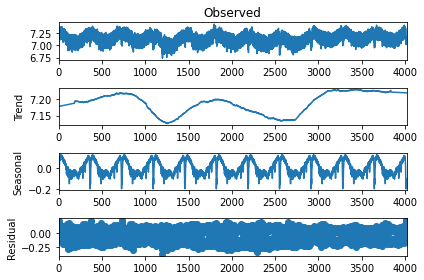

In [35]:
# plot
plt.figure(figsize=(12,8))
decomposition.plot()
plt.show()

The "Observed" subplot shows the original data, the "Trend" subplot indicates the long-term movement in the data abstracting from the seasonality, the "Seasonal" subplot displays the repeating pattern within each period (in this case, a year), and the "Residual" subplot shows the irregularities or noise that is not explained by the trend or seasonal components.

The top plot displays the original time series data with clear fluctuations over time. The second plot shows the trend component of the data. There doesn't appear to be a strong upward or downward trend, which implies relative stability in the data's long-term movement. The third plot reveals the seasonal pattern within a year. The regular oscillations correspond to the specified period of 365 days, likely seasonality associated with factors like weather, holidays, or other cyclical events. The bottom plot shows the residuals after removing the trend and seasonal components. The residuals seem to fluctuate around a mean of zero, with no apparent pattern, which is a good sign. 

The seasonal decomposition helps understand the underlying structure of the time series data. By isolating the trend and seasonal elements, it better models the time series for forecasting or analysis. The lack of a strong trend and the presence of seasonality are particularly useful insights for developing appropriate models, such as SARIMA (Seasonal ARIMA), which can handle both non-seasonal and seasonal components.

### 4. Model the stationary series

Q8 - Taking years of training data is not always the best idea. Based on the decomposition above, what time frame seems the most relevant ?

In [36]:
series = series[-800:]

This is because this series of data from 3200-4000 provides best insight into data trends, seasonality, and residual components.

#### Moving Average (MA) processes

Q9 - Apply a Moving Average process on 20 % of test data. Comment your results.

In [37]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

# train, test & history
size = int(len(series) * 0.8)
train, test = series[0:size], series[size:len(series)]
history = [x for x in train]
predictions = []

In [38]:
# walk forward over time steps in test
for t in range(len(test)):
    model = ARIMA(history, order=(0, 0, 2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

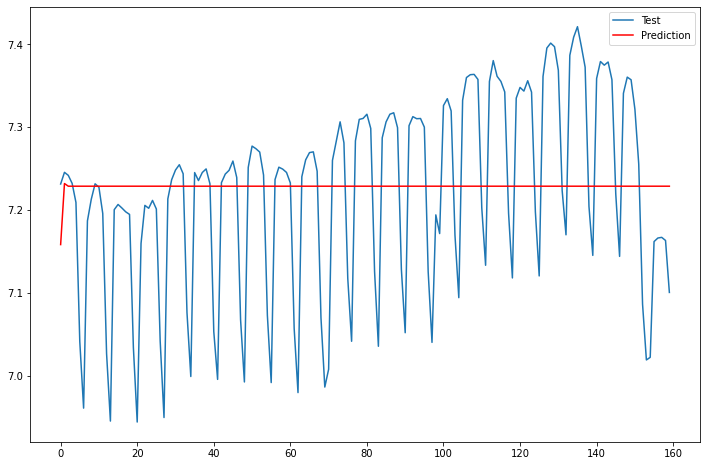

In [39]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(np.array(predictions).reshape(1, -1)[0], color="red", label="Prediction")
plt.legend()
plt.show()

Zoom on the prediction :

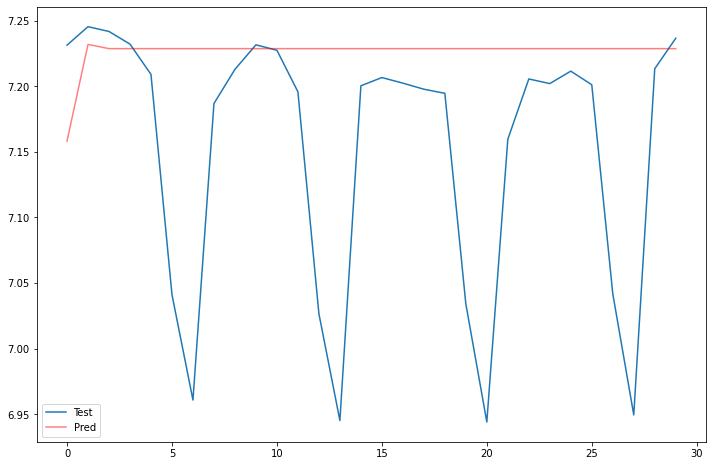

In [40]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(test[:30], label="Test")
plt.plot(np.array(predictions[:30]).reshape(1,-1)[0], color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

In [41]:
# MSE
MSE = mean_squared_error(test, predictions)
print("MSE Score: ", MSE)

MSE Score:  0.013971603244857352


When applying this model to the test data (20% of your dataset), the predict future values based solely on the relationship between the observed error and past forecast errors. There is some lag in the prediction, and we misunderstand the magnitude and the changes.

#### Auto Regressive (AR) processes

Q10 - Apply an Auto Regressive process on 20 % of test data. Comment your results.

In [42]:
split_size = int(len(series) * 0.8)
train, test = series[0:split_size], series[split_size:len(series)]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(2,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

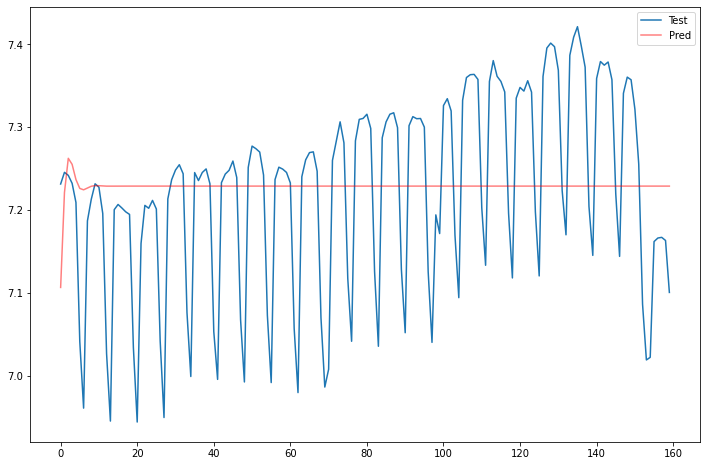

In [43]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(np.array(predictions).reshape(1,-1)[0], color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

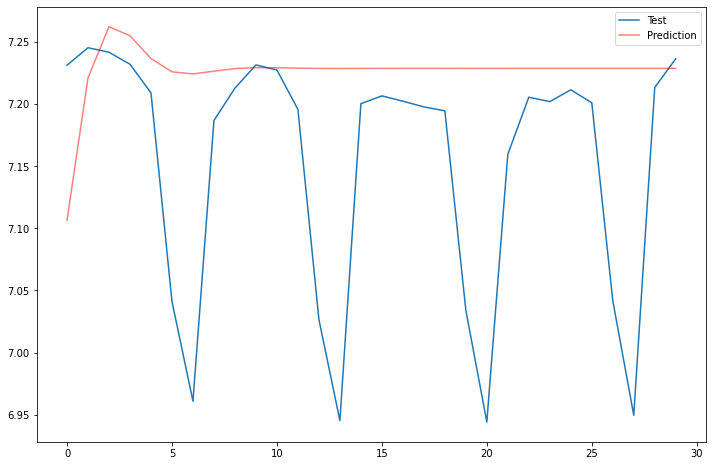

In [44]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(test[:30], label="Test")
plt.plot(np.array(predictions[:30]).reshape(1,-1)[0], color='red',alpha=0.5, label="Prediction")
plt.legend()
plt.show()

The AR model is not performing well.

In [45]:
# MSE
MSE = mean_squared_error(test, predictions)
print("MSE Score: ", MSE)

MSE Score:  0.014023936914717747


#### Auto Regressive Moving Average (ARMA) processes

Q11 - Apply an Auto Regressive Moving Average process on 20 % of test data. Comment your results.

In [56]:
from statsmodels.tsa.arima_model import ARMA

train, test = series[0:split_size], series[split_size:len(series)]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARMA(history, (2, 2, 2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

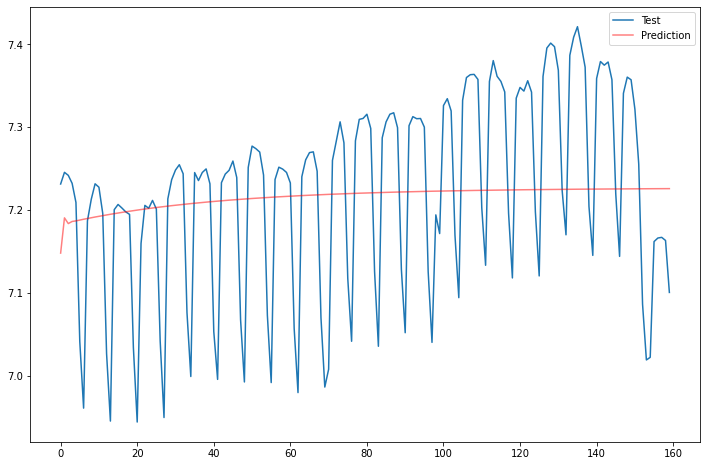

In [57]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(np.array(predictions).reshape(1,-1)[0], color='red',alpha=0.5, label="Prediction")
plt.legend()
plt.show()

Zoom on the prediction :

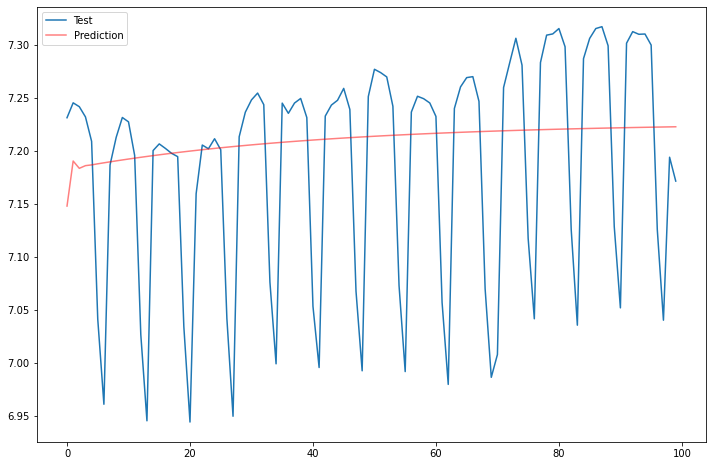

In [58]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(test[:100], label="Test")
plt.plot(np.array(predictions[:100]).reshape(1,-1)[0], color='red',alpha=0.5, label="Prediction")
plt.legend()
plt.show()

In [59]:
# MSE
MSE = mean_squared_error(test, predictions)
print("MSE Score: ", MSE)

MSE Score:  0.01318563912244924


We improved the Mean Squared Error just a little.

#### Auto Regressive Integrated Moving Average (ARIMA) processes

Q12 - Apply an Auto Regressive Integrated Moving Average process on 5 % of test data. Comment your results.

In [51]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

train, test = series[:split_size], series[split_size:]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = SARIMAX(history, order=(0, 0, 2), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

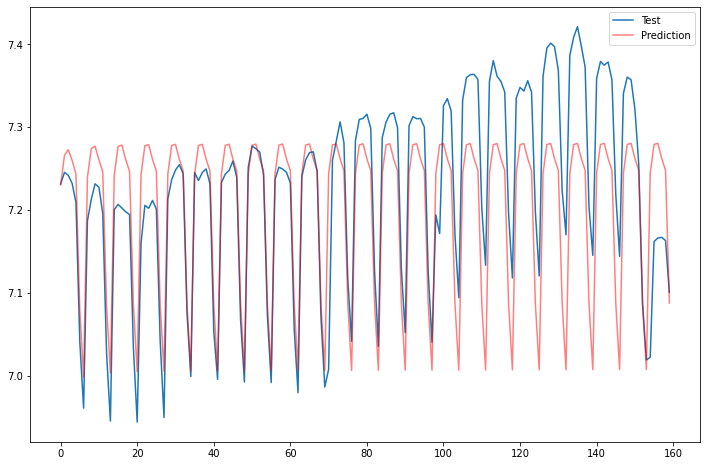

In [52]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(np.array(predictions).reshape(1,-1)[0], color='red',alpha=0.5, label="Prediction")
plt.legend()
plt.show()

Zoom on the prediction :

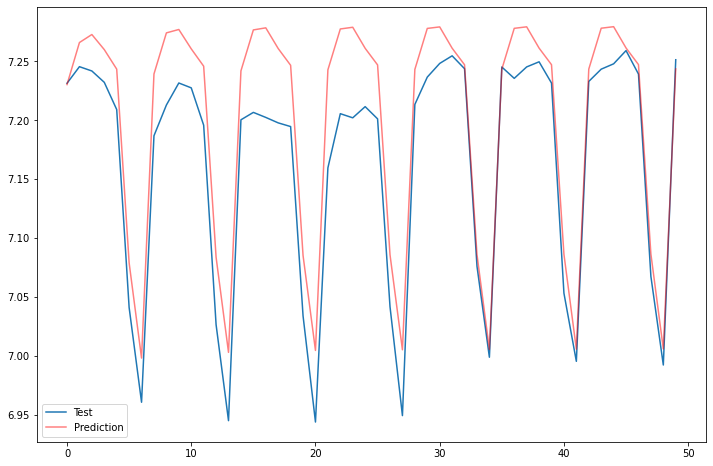

In [53]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(test[:50], label="Test")
plt.plot(np.array(predictions[:50]).reshape(1,-1)[0], color='red',alpha=0.5, label="Prediction")
plt.legend()
plt.show()

In [54]:
# MSE
MSE = mean_squared_error(test, predictions)
print("MSE Score: ", MSE)

MSE Score:  0.0055859836839979495


The MSE value improved significantly. This is the best value so far closest to 0. it is clear in the plot as well, the prediction follows the test data well.

#### Seasonal Autoregressive Integrated Moving-Average (SARIMA) process

Q13 - There is a seasonal pattern over time that we cannot remove. SARIMA might help ! Fit and predict with a SARIMA model on 80% of the data.

In [63]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

train, test = series[0:split_size], series[split_size:len(series)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = SARIMAX(history, order=(0, 0, 2), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

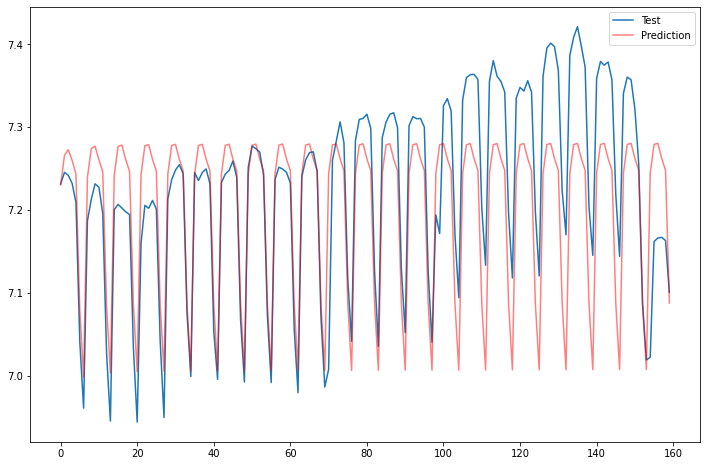

In [64]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(np.array(predictions).reshape(1,-1)[0], color='red',alpha=0.5, label="Prediction")
plt.legend()
plt.show()

Zoom on the prediction :

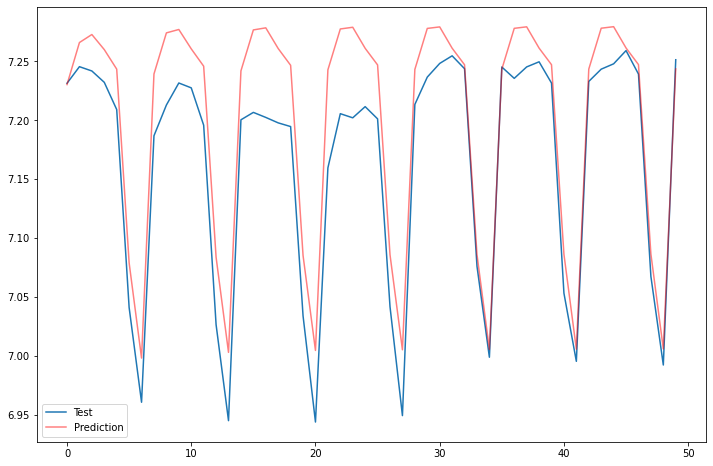

In [65]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(test[:50], label="Test")
plt.plot(np.array(predictions[:50]).reshape(1,-1)[0], color='red',alpha=0.5, label="Prediction")
plt.legend()
plt.show()

In [66]:
MSE = mean_squared_error(test, predictions)
print("MSE Score: ", MSE)

MSE Score:  0.0055859836839979495
